In [40]:
# !pip install inltk
!pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.zip
!unzip 'wiki.hi.zip'

--2022-05-02 20:10:02--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.hi.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2779916118 (2.6G) [application/zip]
Saving to: ‘wiki.hi.zip.1’

wiki.hi.zip.1       100%[===================>]   2.59G  23.2MB/s    in 2m 21s  

2022-05-02 20:12:24 (18.8 MB/s) - ‘wiki.hi.zip.1’ saved [2779916118/2779916118]

Archive:  wiki.hi.zip
replace wiki.hi.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki.hi.vec             
replace wiki.hi.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki.hi.bin             


In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

In [42]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [43]:
# from inltk.inltk import get_embedding_vectors
# from inltk.inltk import setup
# setup("hi")

### Dataset reading and annotations

In [44]:
url = "https://raw.githubusercontent.com/PrynkaSxna/dataset/main/Bhaav-Dataset.csv"
dataset = pd.read_csv(url)

In [45]:
dataset

,Sentences,Annotation
0,रमजान के पूरे तीस रोजों के बाद ईद आयी है,1
1,"कितना मनोहर, कितना सुहावना प्रभाव है",1
2,"वृक्षों पर अजीब हरियाली है, खेतों में कुछ अजीब...",1
3,"आज का सूर्य देखो, कितना प्यारा, कितना शीतल है,...",1
4,गाँव में कितनी हलचल है,1
...,...,...
20299,फिर यहाँ सर्दी हो जाती है,4
20300,दिन-भर मैं यह देखती रहती हूँ कि धूप का टुकड़ा क...,4
20301,"पार्क का कोई ऐसा कोना नहीं, जहाँ मैं घड़ी-आधा घ...",4
20302,लेकिन यह बेंच मुझे सबसे अच्छी लगती है,1


In [46]:
dataset['Annotation'].value_counts()

4    11697
2     3168
1     2463
3     1512
0     1464
Name: Annotation, dtype: int64

In [47]:
dataset['Emotion'] = np.where(
    dataset['Annotation'] == 0, 'Anger', np.where(
        dataset['Annotation'] == 1, 'Joy', np.where(
            dataset['Annotation'] == 2, 'Sad', np.where(
                dataset['Annotation'] == 3, 'Suspense', 'Neutral'))))

In [48]:
dataset['Emotion'].value_counts()

Neutral     11697
Sad          3168
Joy          2463
Suspense     1512
Anger        1464
Name: Emotion, dtype: int64

In [49]:
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = dataset['Annotation'].values
classes = np.unique(y_train_labels)
cls_weights = compute_class_weight(class_weight = "balanced", classes=classes, y= y_train_labels)
class_weights = dict(zip(classes, cls_weights))
class_weights

{0: 2.773770491803279,
 1: 1.648721071863581,
 2: 1.2818181818181817,
 3: 2.6857142857142855,
 4: 0.3471659399846114}

### Convert to TF Dataset and Train/Test Split

In [50]:
full_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(dataset['Sentences'].values, tf.string),
            tf.cast(dataset['Annotation'].values, tf.int32)
        )
    )
)

In [51]:
train_size = int(dataset.shape[0]*0.8)

In [52]:
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

In [53]:
batch_size = 16

In [54]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Preprocessing
* Tokenisation
* Punctuation Removal
* Embed words to ints

In [55]:
max_features = 20000
sequence_length = 150

vectorize_layer = layers.TextVectorization(
    standardize="strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [56]:
train_text = train_dataset.map(lambda x, y: x)

In [57]:
vectorize_layer.adapt(train_text)

In [58]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [59]:
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'\xe0\xa4\xb0\xe0\xa4\xae\xe0\xa4\x9c\xe0\xa4\xbe\xe0\xa4\xa8 \xe0\xa4\x95\xe0\xa5\x87 \xe0\xa4\xaa\xe0\xa5\x82\xe0\xa4\xb0\xe0\xa5\x87 \xe0\xa4\xa4\xe0\xa5\x80\xe0\xa4\xb8 \xe0\xa4\xb0\xe0\xa5\x8b\xe0\xa4\x9c\xe0\xa5\x8b\xe0\xa4\x82 \xe0\xa4\x95\xe0\xa5\x87 \xe0\xa4\xac\xe0\xa4\xbe\xe0\xa4\xa6 \xe0\xa4\x88\xe0\xa4\xa6 \xe0\xa4\x86\xe0\xa4\xaf\xe0\xa5\x80 \xe0\xa4\xb9\xe0\xa5\x88', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 150), dtype=int64, numpy=
array([[10264,     2,   839,  2833, 10097,     2,    78,  2223,   320,
            7,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   

In [60]:
train_ds = train_dataset.map(vectorize_text)
val_ds = test_dataset.map(vectorize_text)

In [61]:
vocab = vectorize_layer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))

**Load FastText Word embeddings and Generate Embedding matrix**

In [62]:
import fasttext
import fasttext.util
ft = fasttext.load_model('wiki.hi.bin')
word = "नृत्य"
print("Embedding Shape is {}".format(ft.get_word_vector(word).shape))
print("Nearest Neighbors to {} are:".format(word))
ft.get_nearest_neighbors(word) 

Embedding Shape is (300,)
Nearest Neighbors to नृत्य are:


[(0.8913929462432861, 'नृत्य।'),
 (0.8440190553665161, 'नृत्यगान'),
 (0.8374733924865723, 'नृत्यगीत'),
 (0.8336297869682312, 'नृत्यों'),
 (0.8265783190727234, 'नृत्यरत'),
 (0.7971948385238647, 'नृत्यकला'),
 (0.7879464626312256, 'नृत्त'),
 (0.7682990431785583, 'नृतक'),
 (0.7622954845428467, 'नृत्यरचना'),
 (0.7602956295013428, 'नृत्यग्राम')]

In [63]:
embedding_dim = 300

# Prepare embedding matrix
hits = 0
misses = 0
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16233 words (0 misses)


### Model definition

In [64]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False),
  layers.Dropout(0.25),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.25),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         6000000   
                                                                 
 dropout_4 (Dropout)         (None, None, 300)         0         
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               38528     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                      

In [65]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [66]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=class_weights,
    epochs=epochs)

Epoch 1/50
1016/1016 [==============================] - 20s 18ms/step - loss: 1.6591 - sparse_categorical_accuracy: 0.2080 - val_loss: 1.3664 - val_sparse_categorical_accuracy: 0.6646
Epoch 2/50
1016/1016 [==============================] - 11s 11ms/step - loss: 1.6499 - sparse_categorical_accuracy: 0.1937 - val_loss: 1.3288 - val_sparse_categorical_accuracy: 0.6639
Epoch 3/50
1016/1016 [==============================] - 11s 10ms/step - loss: 1.6287 - sparse_categorical_accuracy: 0.2390 - val_loss: 1.3071 - val_sparse_categorical_accuracy: 0.6353
Epoch 4/50
1016/1016 [==============================] - 12s 11ms/step - loss: 1.6175 - sparse_categorical_accuracy: 0.2479 - val_loss: 1.3338 - val_sparse_categorical_accuracy: 0.5888
Epoch 5/50
1016/1016 [==============================] - 10s 10ms/step - loss: 1.6085 - sparse_categorical_accuracy: 0.2460 - val_loss: 1.2773 - val_sparse_categorical_accuracy: 0.5994
Epoch 6/50
1016/1016 [==============================] - 11s 11ms/step - loss: 1.

In [67]:
val_softmax = model.predict(val_ds)

In [68]:
val_labels = np.argmax(val_softmax, axis=1)

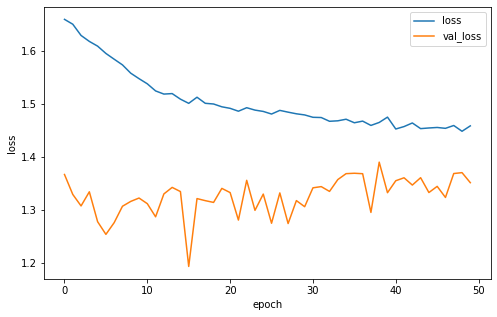

In [69]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(xlabel='epoch', ylabel='loss', figsize=(8,5))

In [70]:
val_pd = dataset[train_size:]
val_pd['pred_labels'] = val_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
print(classification_report(val_pd['Annotation'], val_pd['pred_labels']))

              precision    recall  f1-score   support

           0       0.14      0.27      0.18       183
           1       0.19      0.46      0.27       416
           2       0.35      0.17      0.23       625
           3       0.07      0.48      0.13       138
           4       0.76      0.43      0.55      2699

    accuracy                           0.38      4061
   macro avg       0.30      0.36      0.27      4061
weighted avg       0.59      0.38      0.44      4061



In [72]:
# val_pd['pred_labels'].value_counts()

In [73]:
# val_pd['Annotation'].value_counts()

### LSTM

In [74]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim, mask_zero=True, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False),
    tf.keras.layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         6000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 6,095,685
Trainable params: 95,685
Non-trainable params: 6,000,000
_________________________________________________________________


In [75]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [76]:
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    class_weight=class_weights,
    epochs=epochs)

Epoch 1/50
1016/1016 [==============================] - 106s 100ms/step - loss: 1.6728 - sparse_categorical_accuracy: 0.1428 - val_loss: 1.5934 - val_sparse_categorical_accuracy: 0.0396
Epoch 2/50
1016/1016 [==============================] - 100s 98ms/step - loss: 1.6450 - sparse_categorical_accuracy: 0.1754 - val_loss: 1.5446 - val_sparse_categorical_accuracy: 0.1682
Epoch 3/50
1016/1016 [==============================] - 99s 97ms/step - loss: 1.6002 - sparse_categorical_accuracy: 0.2310 - val_loss: 1.4928 - val_sparse_categorical_accuracy: 0.3090
Epoch 4/50
1016/1016 [==============================] - 101s 99ms/step - loss: 1.5515 - sparse_categorical_accuracy: 0.2603 - val_loss: 1.4844 - val_sparse_categorical_accuracy: 0.2755
Epoch 5/50
1016/1016 [==============================] - 99s 97ms/step - loss: 1.5158 - sparse_categorical_accuracy: 0.2703 - val_loss: 1.4486 - val_sparse_categorical_accuracy: 0.3218
Epoch 6/50
1016/1016 [==============================] - 98s 96ms/step - loss

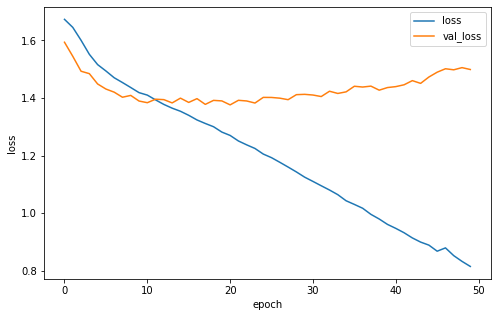

In [77]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(xlabel='epoch', ylabel='loss', figsize=(8,5))

In [78]:
val_softmax = model.predict(val_ds)
val_labels = np.argmax(val_softmax, axis=1)

val_pd['lstm_pred'] = val_labels

print(classification_report(val_pd['Annotation'], val_pd['lstm_pred']))

              precision    recall  f1-score   support

           0       0.10      0.17      0.12       183
           1       0.19      0.38      0.25       416
           2       0.27      0.50      0.35       625
           3       0.08      0.32      0.13       138
           4       0.78      0.35      0.48      2699

    accuracy                           0.37      4061
   macro avg       0.28      0.34      0.27      4061
weighted avg       0.59      0.37      0.41      4061



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
